In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all'

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)

In [4]:
from tqdm import tqdm

In [5]:
from sklearn.preprocessing import LabelEncoder

from sktime.distances import distance
from sktime.transformations.panel.dictionary_based import PAAlegacy as PAA

In [6]:
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler

In [7]:
import matplotlib.colors as clr
cmap = clr.LinearSegmentedColormap.from_list('custom_map', [ 'white', '#015697'], N=256)

In [8]:
def load_npy(filename):
    with open(filename, 'rb') as f:
        return np.load(f)

In [9]:
dir_path = '/Users/shtk/DM PRJ 2/time_series/'
len_threshold = 1280

In [10]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)
    
    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad) 

    X.append(ts)

#X, y, ids = np.array(X), np.array(y), np.array(ids)

In [11]:
#ts = pd.DataFrame(X)
#df = ts.copy()
df = pd.DataFrame(X)
df['genre'] = y
df['genre_en'] = LabelEncoder().fit_transform(df['genre'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1272,1273,1274,1275,1276,1277,1278,1279,genre,genre_en
0,768.953928,828.022584,941.386304,945.749554,1159.725465,1240.333451,1423.674344,1634.191655,1828.503961,1847.519588,...,1279.665800,1360.056734,1444.307480,1517.640273,1458.297057,1442.914786,1391.236018,1321.283908,opera,11
1,3230.211119,3344.520081,3136.686050,2845.915331,2808.156723,2651.146880,2495.342218,2549.019959,2661.295847,2727.635261,...,3191.035809,2830.924961,2308.329541,1724.827512,1325.563666,1130.380398,978.286919,899.698980,minimal-techno,8
2,2192.694219,1986.904857,2082.598864,2254.738538,2401.683572,2407.616566,2217.455236,2091.153692,1957.757435,1862.646861,...,3222.103029,3303.188014,3347.910378,3343.393614,3378.469131,3533.683709,3432.652557,3476.442086,goth,2
3,1050.270174,1122.238261,1176.087855,1132.076020,1099.776970,1044.397110,1017.142440,1071.410733,1101.055515,1114.730346,...,859.559805,802.391176,798.260556,753.313485,770.064609,804.954898,839.047077,851.398559,opera,11
4,2467.430056,2222.344861,2053.680022,1733.958104,1115.226422,821.548505,964.249252,1550.314474,2235.348186,2176.156140,...,1417.110211,1939.536578,1798.345901,1245.512644,1079.249670,1005.486618,926.054992,964.566937,minimal-techno,8


In [12]:
df = pd.DataFrame(X)
df['genre_en'] = LabelEncoder().fit_transform(y)

In [13]:
def sample_genre_rows(df, feature='genre', n=3):
    return df.groupby(feature).apply(lambda x: x.sample(n)).reset_index(drop=True)

#df_sampled = sample_genre_rows(df, n=50)
#df_sampled.head()

In [14]:
df_sampled = sample_genre_rows(df,feature='genre_en', n=50)

## Preprocessing

In [15]:
def transform(data, scalar):
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    return scaled_data

In [36]:
scaler = TabularToSeriesAdaptor(StandardScaler())
scaled_data = transform(df.iloc[:, :-2].T.values, scaler)

In [18]:
scaler = TabularToSeriesAdaptor(StandardScaler())
scaled_data = transform(df_sampled.iloc[:, :-2].T.values, scaler)

In [37]:
amp_ts = scaled_data.T
amp_ts['genre'] = df['genre']
amp_ts.head()

,0,1,2,3,4,5,6,7,8,9,...,1271,1272,1273,1274,1275,1276,1277,1278,1279,genre
0,-1.629172,-1.520961,-1.313285,-1.305292,-0.913300,-0.765631,-0.429760,-0.044104,0.311865,0.346700,...,-0.582472,-0.693576,-0.546304,-0.391962,-0.257620,-0.366334,-0.394513,-0.489186,-0.617334,opera
1,1.998834,2.145208,1.879073,1.506736,1.458385,1.257331,1.057821,1.126556,1.270327,1.355276,...,1.312998,1.948669,1.487540,0.818348,0.071163,-0.440102,-0.690038,-0.884796,-0.985429,minimal-techno
2,-0.147832,-0.514944,-0.344234,-0.037150,0.224988,0.235572,-0.103660,-0.328972,-0.566941,-0.736611,...,1.336984,1.688552,1.833202,1.912983,1.904925,1.967497,2.244388,2.064156,2.142273,goth
3,-1.106353,-0.859716,-0.675172,-0.826002,-0.936692,-1.126481,-1.219883,-1.033904,-0.932310,-0.885446,...,-1.699053,-1.759925,-1.955844,-1.969999,-2.124035,-2.066628,-1.947058,-1.830222,-1.787894,opera
4,1.200894,0.828193,0.571704,0.085503,-0.855402,-1.301998,-1.084993,-0.193764,0.847967,0.757954,...,-1.389521,-0.396327,0.398126,0.183418,-0.657276,-0.910112,-1.022283,-1.143075,-1.084510,minimal-techno


In [19]:
amp_ts_s = scaled_data.T
amp_ts_s['genre'] = df_sampled['genre_en']
amp_ts_s.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,genre
0,-0.558798,-0.441224,-0.351829,-0.366478,-0.279388,-0.154725,-0.134325,0.269036,0.278988,0.325782,...,4.500874,4.729630,4.767068,4.776338,4.546831,4.051305,2.254144,0.762882,0.401004,0
1,0.559855,0.591479,0.711297,0.814933,0.846264,0.128803,-1.042110,-1.210777,-0.002836,0.454374,...,-0.000990,0.387805,0.063144,-0.446526,-0.524950,-0.393108,-0.506121,-0.391274,-0.471588,0
2,-0.844568,-0.502855,-0.178395,0.149318,0.404155,0.925050,1.334791,0.335569,-0.415452,0.396904,...,-1.399780,-0.555905,-0.662814,-0.287749,-0.452370,-0.688018,-0.767529,-0.743189,-0.607905,0
3,-0.133895,0.559173,0.958210,0.926600,1.014849,1.060344,0.942589,0.597796,0.218269,-0.629787,...,-1.256626,-1.542594,-1.668058,-0.737246,-1.086439,-2.093028,-2.347824,-2.183563,-2.378883,0
4,-0.830261,-0.810418,-0.715178,-0.336331,-0.160109,-0.605159,-0.943734,-0.957726,-0.945797,-0.855445,...,0.493832,-1.196258,-1.611149,-1.035110,-0.659274,-0.616619,-0.595162,-0.448877,0.800777,0


In [81]:
approx_paa_full.to_csv('approx_paa.csv', index=False
                      )

### approx

In [16]:
def df_dft(df, n_coefs=160):
    approx_dft = []

    for i in df.index:
        approx = dft(df.iloc[i, :1280], n_coefs=n_coefs)
        approx_dft.append(approx.ravel())
    approx_dft = pd.DataFrame(approx_dft)
    approx_dft['genre'] = df['genre']
    
    return approx_dft

def df_paa(df, num_intervals=160):
    approx_paa = []
    for i in df.index:
        paa = PAA(num_intervals=num_intervals)
        y_paa = paa.fit_transform(df.iloc[i, :1280].values)
        approx_paa.append(y_paa.ravel())
    approx_paa = pd.DataFrame(approx_paa)
    approx_paa['genre'] = df['genre']
    return approx_paa

def df_sax(df, alphabet_size=10, word_size=160):
    approx_sax = []
    for i in df.index:
        sax = SAX(word_size=word_size, alphabet_size=alphabet_size)
        y_sax = sax.fit_transform(df.iloc[i, :1280].values)
        approx_sax.append(y_sax.ravel())
    approx_sax = pd.DataFrame(approx_sax)
    approx_sax['genre'] = df['genre']
    return approx_sax

In [39]:
approx_paa_full = df_paa(amp_ts, num_intervals=160)

In [16]:
sampled = sample_genre_rows(amp_ts, n=50)

In [20]:
approx_paa_s = df_paa(amp_ts_s, num_intervals=160)

## Classification

In [21]:
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Splitting the data

In [22]:
X, y = approx_paa_s.iloc[:, :-1], approx_paa_s['genre']
#X, y = approx_paa_full.iloc[:, :-1], approx_paa_full['genre']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 160), (300, 160), (700,), (300,))

In [24]:
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [42]:
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
X_train_scaled_f = scaler.fit_transform(X_train.values)
X_test_scaled_f = scaler.transform(X_test.values)

### KNN euclidean

In [25]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw, cdist_dtw

In [26]:
from sklearn.metrics import classification_report

In [62]:
knn = KNeighborsTimeSeriesClassifier()

In [77]:
%time
knn = KNeighborsTimeSeriesClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 10, 15, 25, 35, 50, 75, 100],     # Number of neighbors to use
    'weights': ['uniform', 'distance'],      # Weight function used in prediction
    'metric': ['euclidean']     # Distance metric
}

grid_search = GridSearchCV(
    knn,
    param_grid,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
)



# Fit the grid search to the training data
grid_search.fit(X_train_scaled_f, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 24.1 µs
Best parameters: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
Best score: 0.1


In [54]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [78]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=10, metric="euclidean", weights='distance')
knn.fit(X_train_scaled_f, y_train.values)
y_pred = knn.predict(X_test_scaled_f)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.67      0.01      0.03       150
             folk       0.24      0.03      0.06       150
             goth       0.20      0.02      0.04       150
            happy       0.16      0.31      0.21       150
      heavy-metal       0.00      0.00      0.00       150
       honky-tonk       0.50      0.03      0.06       150
           j-idol       0.62      0.05      0.10       150
             kids       0.00      0.00      0.00       150
   minimal-techno       0.08      0.80      0.15       150
              mpb       0.50      0.01      0.01       150
          new-age       0.17      0.03      0.06       150
            opera       0.10      0.01      0.01       150
            piano       0.23      0.03      0.06       150
progressive-house       0.19      0.21      0.20       150
            salsa       0.06      0.14      0.09       150
        sertanejo       0.67      0.01      0.03       

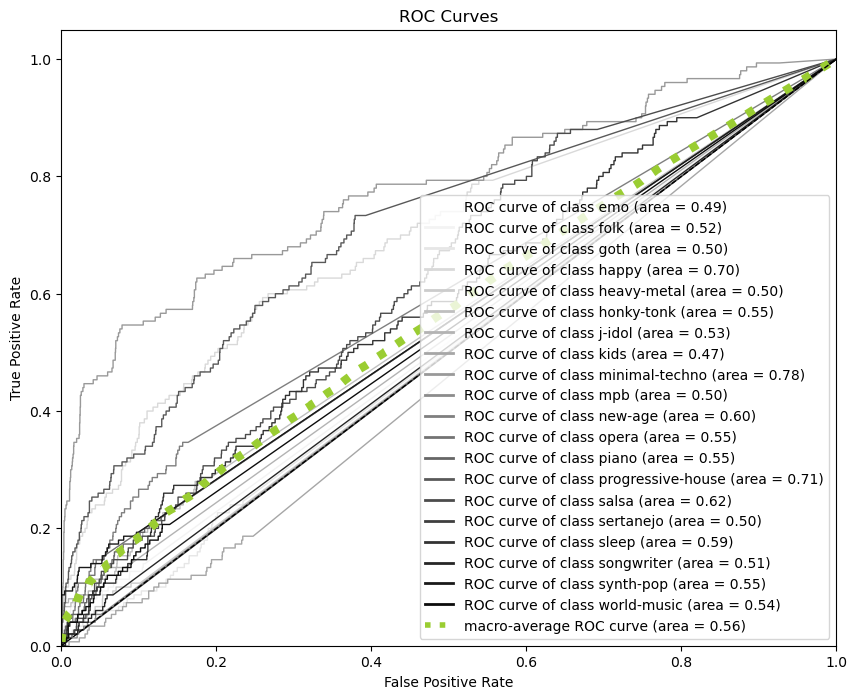

In [79]:
def plot_roc_cust(y_test, y_test_pred_proba):
    ax = plot_roc(y_test, y_test_pred_proba, figsize = (10,8), cmap = "binary", plot_micro=False)
    
    for line in ax.lines:
        line.set_linewidth(1)
    
    macro = ax.lines[-2]
    macro.set_color('yellowgreen')
    macro.set_linewidth(6)
    
    legend = ax.get_legend()
    legend.legendHandles[-1].set_color('yellowgreen')

    plt.show()

from scikitplot.metrics import plot_roc
y_test_pred_proba = knn.predict_proba(X_test_scaled_f)
plot_roc_cust(y_test, y_test_pred_proba)

### KNN DTW

In [34]:
%%time
# approx_paa

# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw", metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":3})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


                   precision    recall  f1-score   support

              emo       0.14      0.07      0.09        15
             folk       0.00      0.00      0.00        15
             goth       0.13      0.20      0.16        15
            happy       0.06      0.07      0.06        15
      heavy-metal       0.11      0.07      0.08        15
       honky-tonk       0.09      0.07      0.08        15
           j-idol       0.00      0.00      0.00        15
             kids       0.00      0.00      0.00        15
   minimal-techno       0.13      0.60      0.22        15
              mpb       0.00      0.00      0.00        15
          new-age       0.33      0.13      0.19        15
            opera       0.50      0.13      0.21        15
            piano       0.17      0.07      0.10        15
progressive-house       0.12      0.27      0.17        15
            salsa       0.03      0.07      0.04        15
        sertanejo       0.00      0.00      0.00       

In [48]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

In [37]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

# Define the number of splits for cross-validation
n_splits = 4

# Create a pipeline with normalization and KNN classification
pipeline = Pipeline([
    ('knn', KNeighborsTimeSeriesClassifier(metric="dtw", metric_params={"global_constraint": "sakoe_chiba"}))
])

# Define the parameter grid including sakoe_chiba_radius
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 9, 15, 25, 35, 55, 75, 105],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric_params': [{'sakoe_chiba_radius': 10}]
}

# Set up the GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)



# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'knn__metric_params': {'sakoe_chiba_radius': 20}, 'knn__n_neighbors': 35, 'knn__weights': 'distance'}
Best score: 0.12714285714285714


In [46]:
%%time
# Define the number of splits for cross-validation
n_splits = 4

# Create a pipeline with normalization and KNN classification
pipeline = Pipeline([
    ('knn', KNeighborsTimeSeriesClassifier(metric="dtw", metric_params={"global_constraint": "sakoe_chiba"}))
])

# Define the parameter grid including sakoe_chiba_radius
param_grid = {
    'knn__n_neighbors': [1, 3, 5, 9, 15, 25, 35, 55, 75, 105],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric_params': [{'sakoe_chiba_radius': 10}]
}

# Set up the GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)



# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'knn__metric_params': {'sakoe_chiba_radius': 10}, 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best score: 0.11
CPU times: user 11min 53s, sys: 1.31 s, total: 11min 55s
Wall time: 11min 55s


In [39]:
%%time
# approx_paa

# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":50})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.22      0.13      0.17        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.43      0.20      0.27        15
           j-idol       0.00      0.00      0.00        15
             kids       0.08      0.07      0.07        15
   minimal-techno       0.18      0.80      0.30        15
              mpb       0.33      0.07      0.11        15
          new-age       0.31      0.33      0.32        15
            opera       0.00      0.00      0.00        15
            piano       0.00      0.00      0.00        15
progressive-house       0.13      0.13      0.13        15
            salsa       0.06      0.40      0.10        15
        sertanejo       0.00      0.00      0.00       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
list(range(20, 200, 10))

[20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190]

In [29]:
r_radius = [5, 7, 11, 15, 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150]
scores = list()

for r in tqdm(r_radius):
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":r})
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(X_test_scaled, y_test))
    
    
    
    

100%|███████████████████████████████████████████| 18/18 [09:32<00:00, 31.78s/it]


Text(0.5, 1.0, 'Test accuracy by changing Sakoe-Chiba radius')

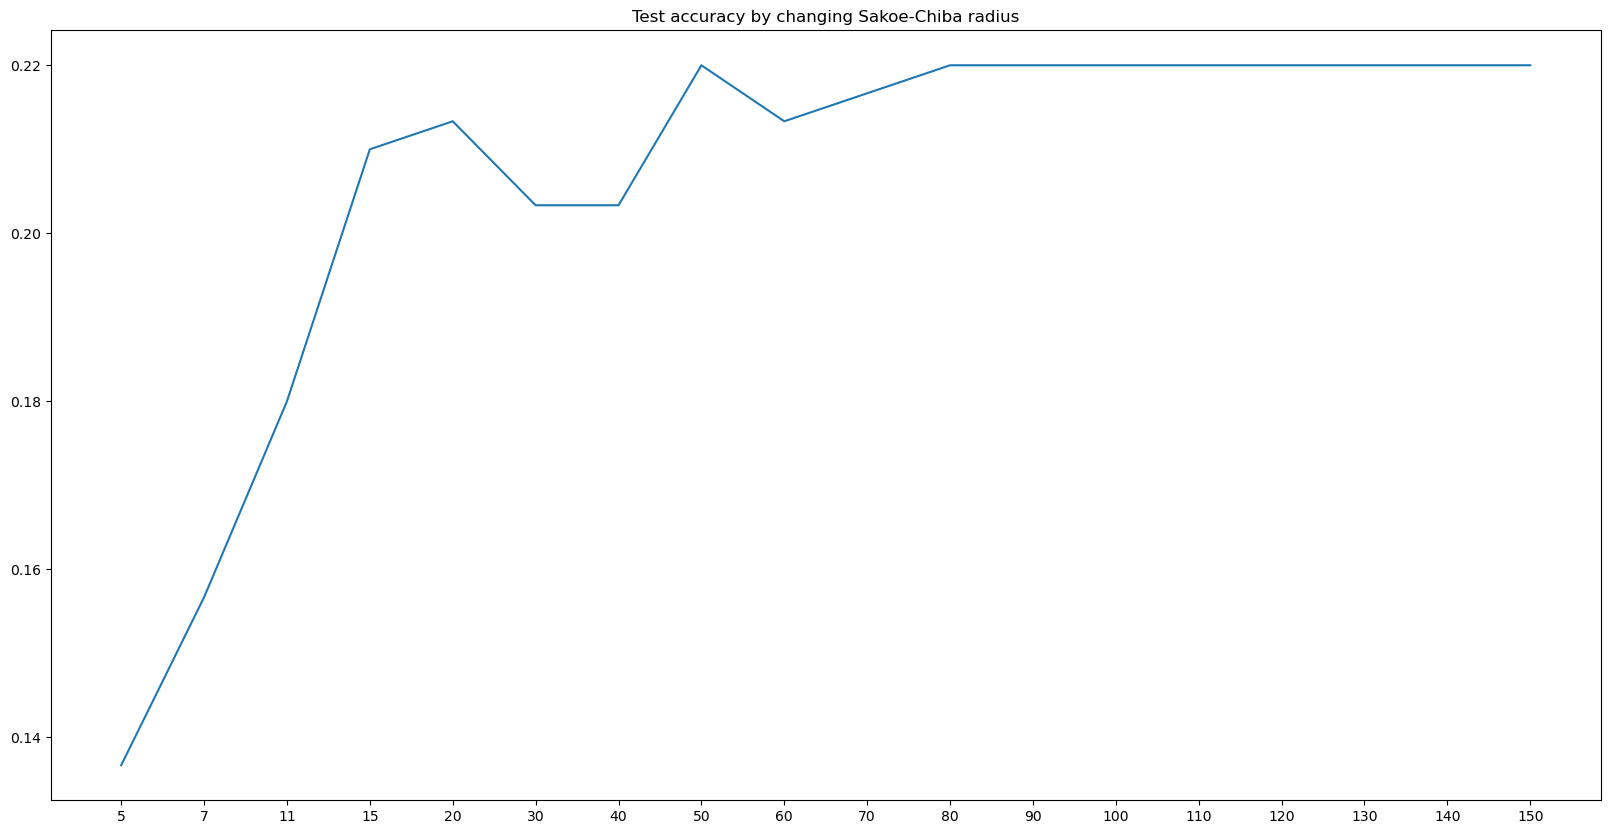

In [31]:
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(r_radius)), r_radius)
plt.title('Test accuracy by changing Sakoe-Chiba radius')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


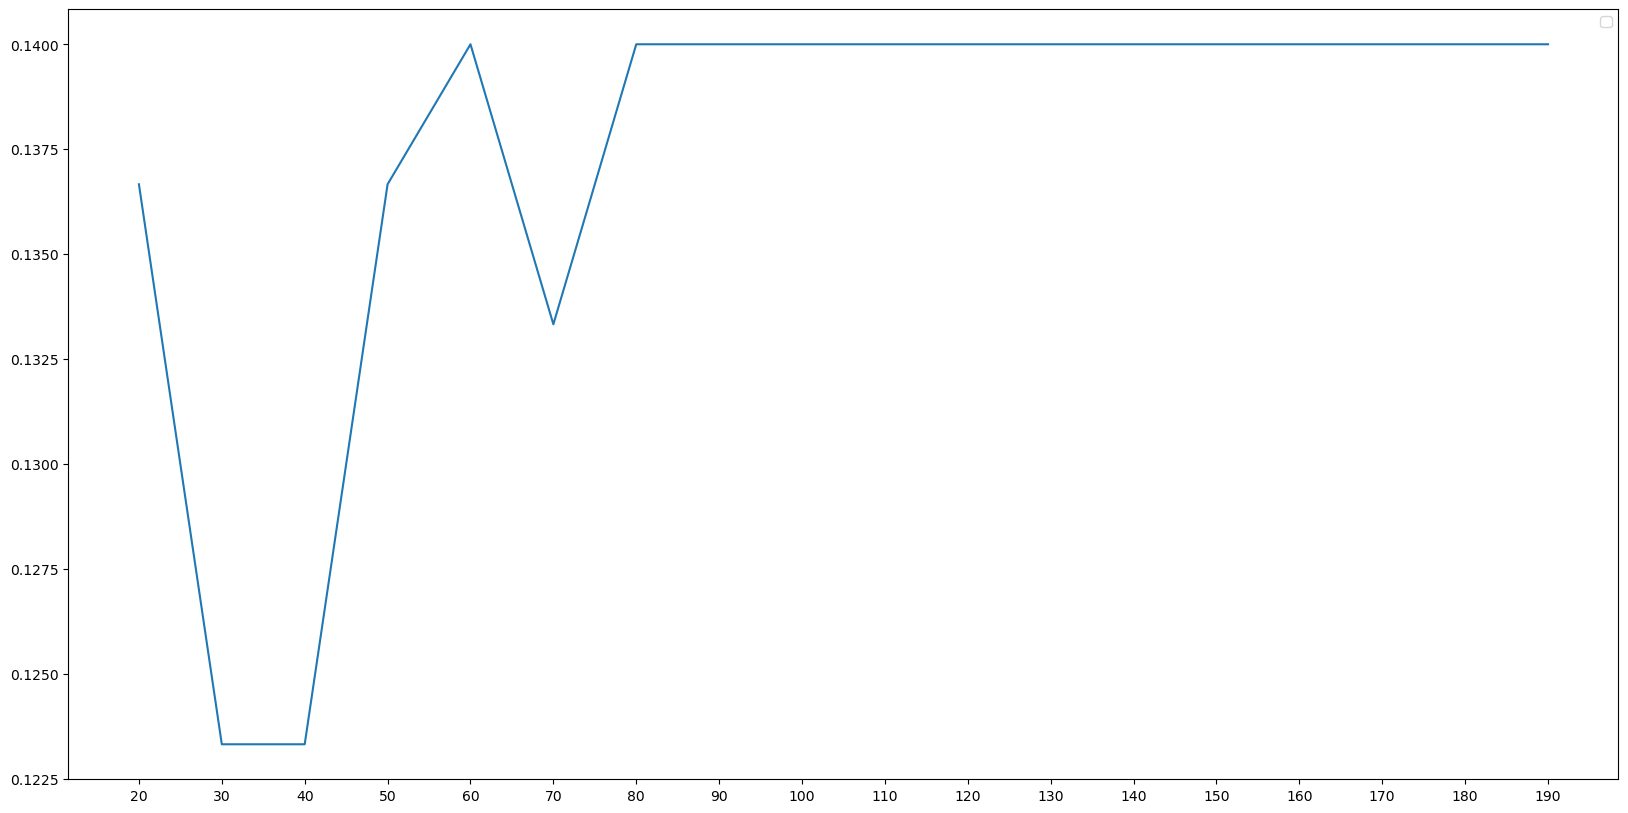

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(r_radius)), r_radius)
plt.legend()

In [52]:
len(X_test_scaled), len(y_pred)

(300, 300)

  0%|                                                    | 0/18 [00:00<?, ?it/s]/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 44%|███████████████████▌                        | 8/18 [07:58<10:54, 65.42s/it]/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


 89%|██████████████████████████████████████▏    | 16/18 [18:05<02:32, 76.27s/it]/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


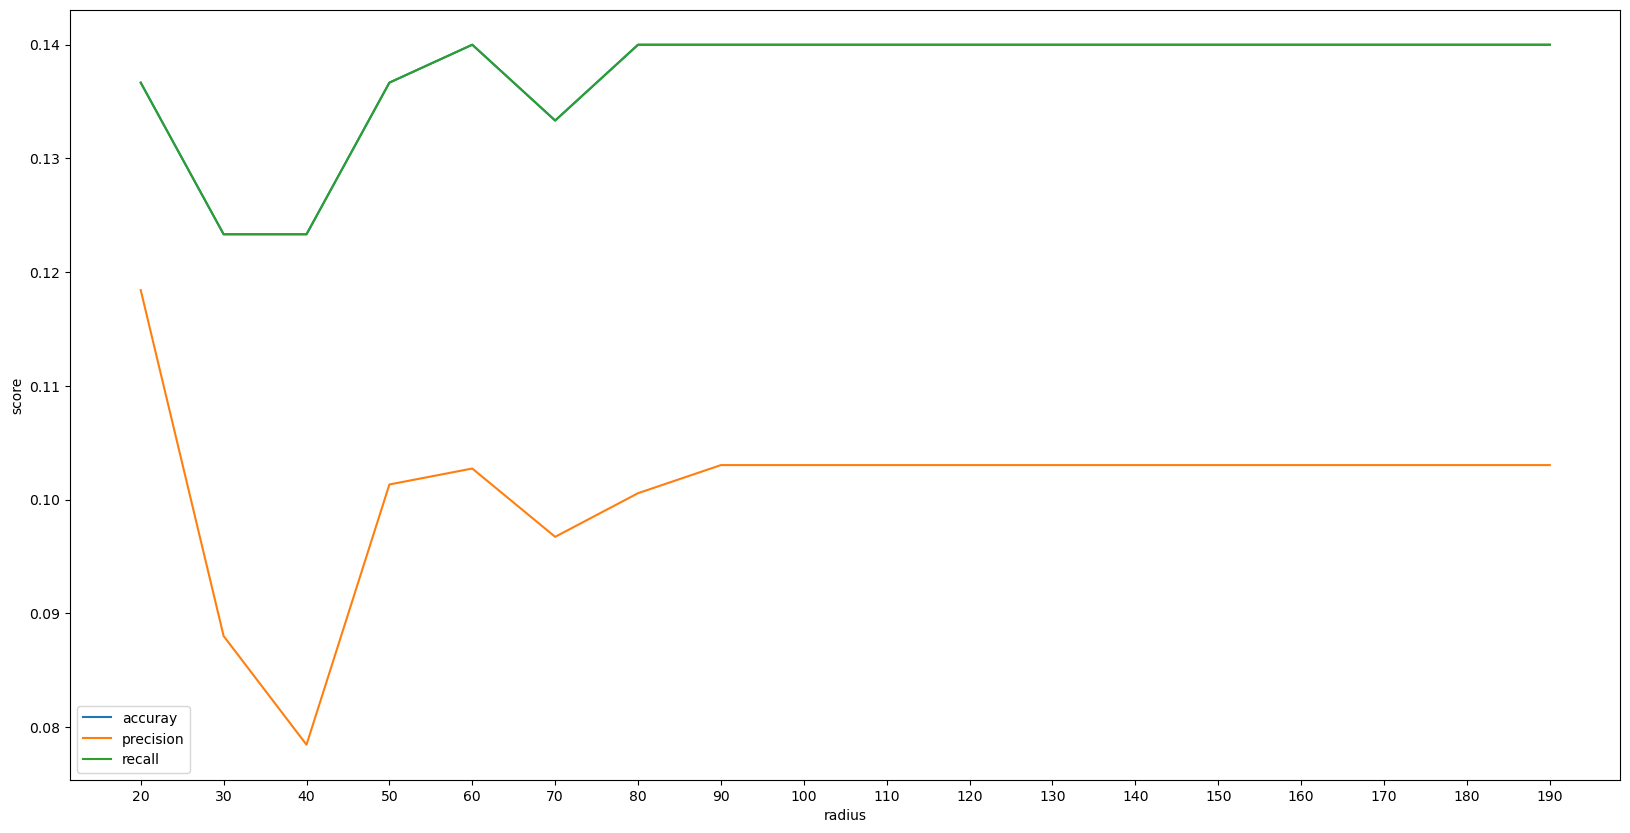

In [54]:
r_radius = range(20, 200, 10)
scores = list()
precision_scores = list()
recall_scores = list()
for r in tqdm(r_radius):
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":r})
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(X_test_scaled, y_test))
    
    y_pred = clf.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])

# Plot the precision, recall, and F1 scores for each value of k
plt.figure(figsize=(20, 10))
plt.plot(scores, label='accuray')

plt.plot(precision_scores, label='precision')
plt.plot(recall_scores, label='recall')
plt.xticks(range(len(r_radius)), r_radius)
#plt.title('Classification Performance for Different Values of k')
plt.xlabel('radius')
plt.ylabel('score')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████| 3/3 [02:02<00:00, 40.92s/it]


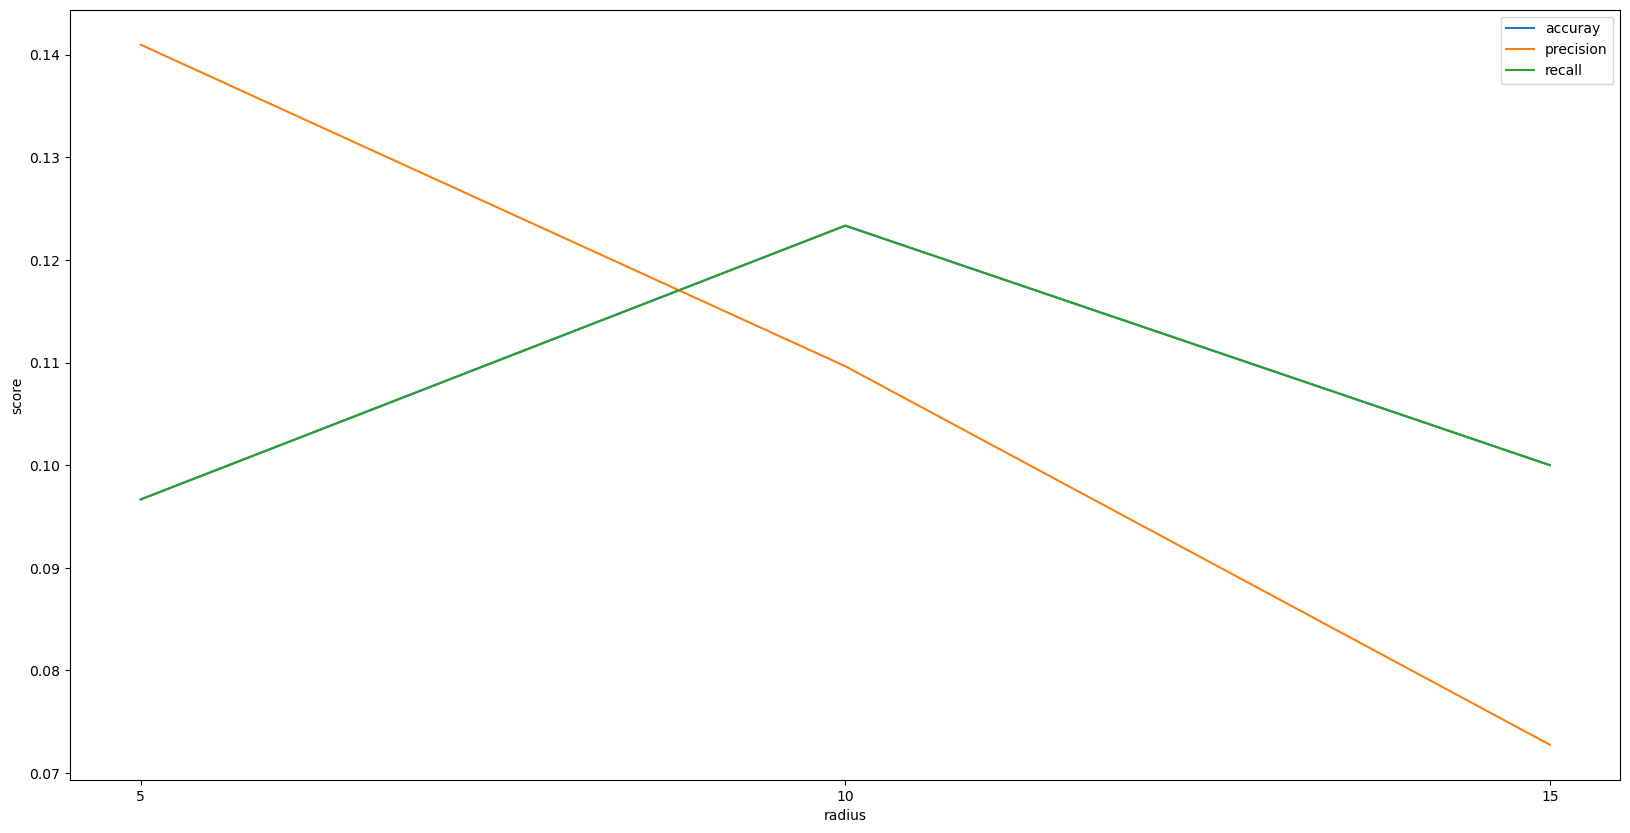

In [59]:
r_radius = range(5, 20, 5)
scores = list()
precision_scores = list()
recall_scores = list()
for r in tqdm(r_radius):
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=9, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":r})
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(X_test_scaled, y_test))
    
    y_pred = clf.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])

# Plot the precision, recall, and F1 scores for each value of k
plt.figure(figsize=(20, 10))
plt.plot(scores, label='accuray')

plt.plot(precision_scores, label='precision')
plt.plot(recall_scores, label='recall')
plt.xticks(range(len(r_radius)), r_radius)
#plt.title('Classification Performance for Different Values of k')
plt.xlabel('radius')
plt.ylabel('score')
plt.legend()
plt.show()

In [40]:
# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":70})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.12      0.07      0.09        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.50      0.27      0.35        15
           j-idol       0.00      0.00      0.00        15
             kids       0.08      0.07      0.07        15
   minimal-techno       0.16      0.73      0.26        15
              mpb       0.25      0.07      0.11        15
          new-age       0.33      0.33      0.33        15
            opera       0.00      0.00      0.00        15
            piano       0.00      0.00      0.00        15
progressive-house       0.14      0.13      0.14        15
            salsa       0.06      0.40      0.10        15
        sertanejo       0.00      0.00      0.00       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
%%time
# Define the number of splits for cross-validation
n_splits = 4

# Create a pipeline with normalization and KNN classification
pipeline = Pipeline([
    ('knn', KNeighborsTimeSeriesClassifier(metric="dtw", metric_params={"global_constraint": "sakoe_chiba"}))
])

# Define the parameter grid including sakoe_chiba_radius
param_grid = {
    'knn__n_neighbors': [3, 5, 9, 15, 25, 35, 55, 75, 105],
    'knn__weights': ['distance', 'uniform'],
    'knn__metric_params': [{'sakoe_chiba_radius': 20}]
}

# Set up the GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
)



# Fit the grid search to the training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'knn__metric_params': {'sakoe_chiba_radius': 90}, 'knn__n_neighbors': 75, 'knn__weights': 'distance'}
Best score: 0.12857142857142856
CPU times: user 9min 15s, sys: 1.35 s, total: 9min 17s
Wall time: 9min 17s


In [61]:
# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=9, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":90})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.17      0.07      0.10        15
             goth       0.00      0.00      0.00        15
            happy       0.00      0.00      0.00        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.31      0.27      0.29        15
           j-idol       0.00      0.00      0.00        15
             kids       0.09      0.07      0.08        15
   minimal-techno       0.23      0.80      0.36        15
              mpb       0.25      0.07      0.11        15
          new-age       0.14      0.20      0.17        15
            opera       0.00      0.00      0.00        15
            piano       0.08      0.07      0.07        15
progressive-house       0.18      0.20      0.19        15
            salsa       0.03      0.13      0.05        15
        sertanejo       0.12      0.07      0.09       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=75, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":90})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.17      0.07      0.10        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.17      0.07      0.10        15
           j-idol       0.00      0.00      0.00        15
             kids       0.17      0.07      0.10        15
   minimal-techno       0.15      0.80      0.25        15
              mpb       0.20      0.07      0.10        15
          new-age       0.32      0.53      0.40        15
            opera       0.00      0.00      0.00        15
            piano       0.00      0.00      0.00        15
progressive-house       0.12      0.07      0.09        15
            salsa       0.05      0.40      0.10        15
        sertanejo       0.18      0.13      0.15       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [64]:
# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":20})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.25      0.07      0.11        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.00      0.00      0.00        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.43      0.20      0.27        15
           j-idol       0.00      0.00      0.00        15
             kids       0.00      0.00      0.00        15
   minimal-techno       0.16      0.80      0.27        15
              mpb       0.00      0.00      0.00        15
          new-age       0.17      0.20      0.18        15
            opera       0.50      0.07      0.12        15
            piano       0.17      0.07      0.10        15
progressive-house       0.23      0.20      0.21        15
            salsa       0.07      0.47      0.13        15
        sertanejo       0.14      0.07      0.09       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

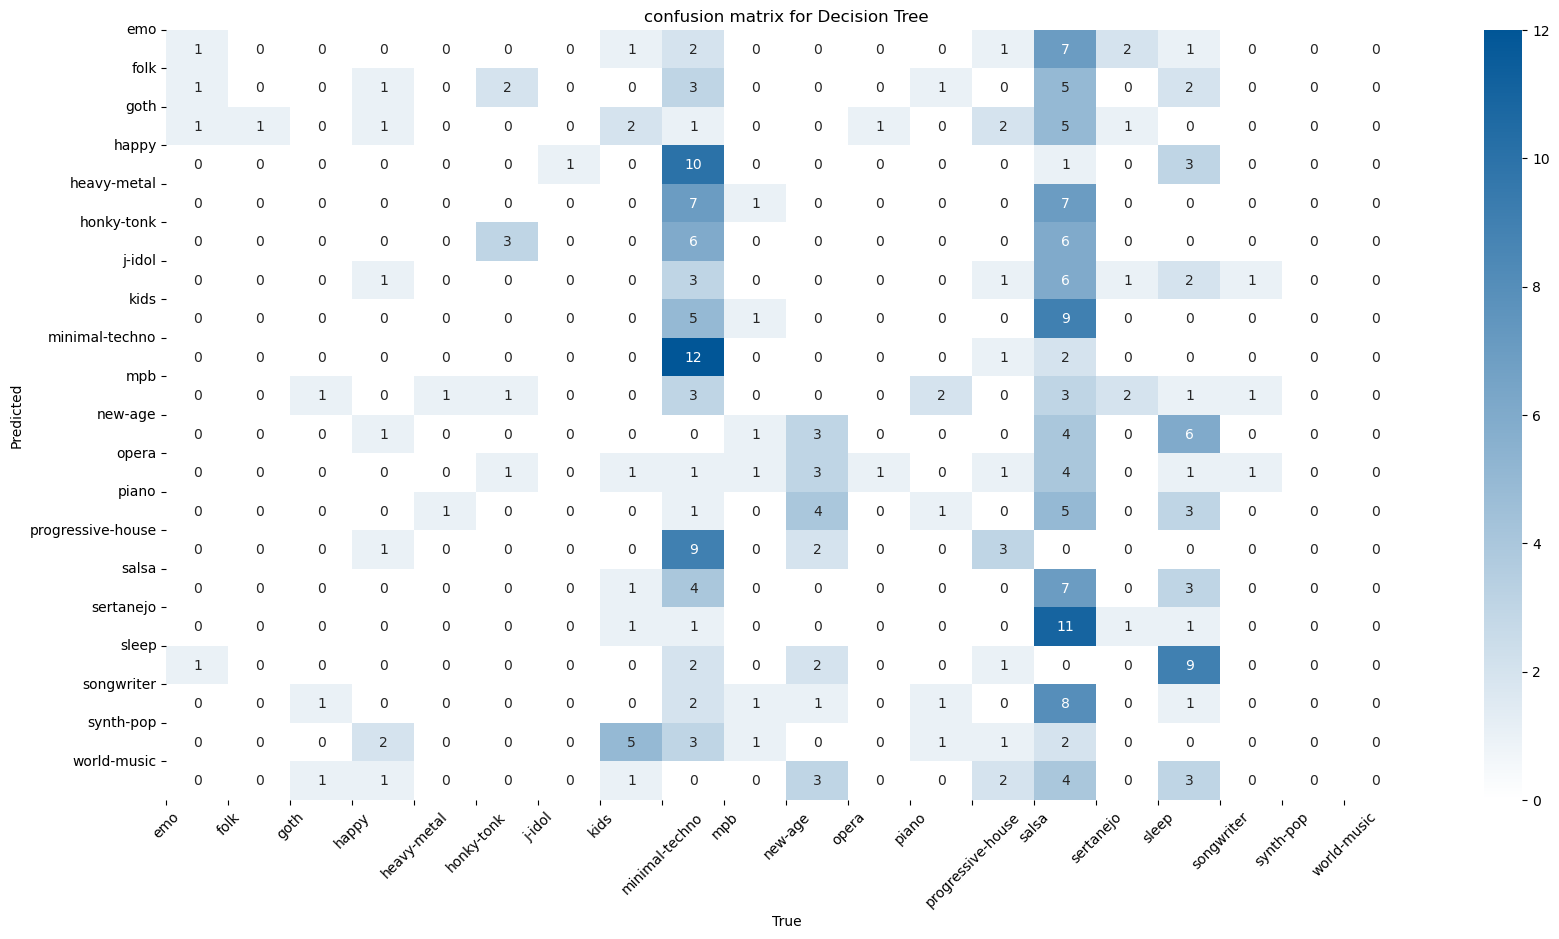

In [73]:
cf = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cf, annot=True, cmap=cmap, fmt=".3g")

plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("confusion matrix for Decision Tree")

plt.xticks(range(len(knn_dtw.classes_)), knn_dtw.classes_, rotation = 45)
plt.yticks(range(len(knn_dtw.classes_)), knn_dtw.classes_, rotation = 360)

plt.show()

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 300 1-dimensional timeseries
  warnings.warn(


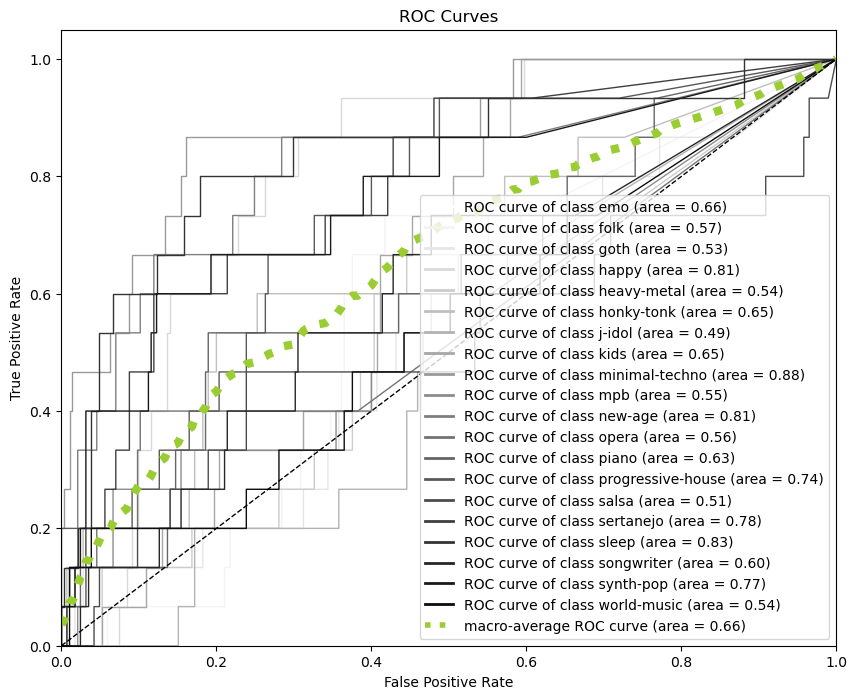

In [74]:
def plot_roc_cust(y_test, y_test_pred_proba):
    ax = plot_roc(y_test, y_test_pred_proba, figsize = (10,8), cmap = "binary", plot_micro=False)
    
    for line in ax.lines:
        line.set_linewidth(1)
    
    macro = ax.lines[-2]
    macro.set_color('yellowgreen')
    macro.set_linewidth(6)
    
    legend = ax.get_legend()
    legend.legendHandles[-1].set_color('yellowgreen')

    plt.show()

from scikitplot.metrics import plot_roc
y_test_pred_proba = knn_dtw.predict_proba(X_test_scaled)
plot_roc_cust(y_test, y_test_pred_proba)

In [75]:
# Define the k-NN classifier with DTW distance
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":90})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.22      0.13      0.17        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.50      0.27      0.35        15
           j-idol       0.00      0.00      0.00        15
             kids       0.08      0.07      0.07        15
   minimal-techno       0.17      0.80      0.28        15
              mpb       0.25      0.07      0.11        15
          new-age       0.33      0.33      0.33        15
            opera       0.00      0.00      0.00        15
            piano       0.00      0.00      0.00        15
progressive-house       0.14      0.13      0.14        15
            salsa       0.06      0.40      0.10        15
        sertanejo       0.00      0.00      0.00       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=75, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":90})

# Fit the classifier
knn_dtw.fit(X_train_scaled, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00        15
             folk       0.00      0.00      0.00        15
             goth       0.00      0.00      0.00        15
            happy       0.17      0.07      0.10        15
      heavy-metal       0.00      0.00      0.00        15
       honky-tonk       0.17      0.07      0.10        15
           j-idol       0.00      0.00      0.00        15
             kids       0.17      0.07      0.10        15
   minimal-techno       0.15      0.80      0.25        15
              mpb       0.20      0.07      0.10        15
          new-age       0.32      0.53      0.40        15
            opera       0.00      0.00      0.00        15
            piano       0.00      0.00      0.00        15
progressive-house       0.12      0.07      0.09        15
            salsa       0.05      0.40      0.10        15
        sertanejo       0.18      0.13      0.15       

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [85]:
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=35, metric="dtw",  weights= 'distance', metric_params={"global_constraint": "sakoe_chiba", "sakoe_chiba_radius":20})

# Fit the classifier
knn_dtw.fit(X_train_scaled_f, y_train)

# Predict the test set
y_pred = knn_dtw.predict(X_test_scaled_f)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.10      0.05      0.07       150
             folk       0.21      0.05      0.08       150
             goth       0.00      0.00      0.00       150
            happy       0.28      0.32      0.30       150
      heavy-metal       0.25      0.02      0.04       150
       honky-tonk       0.19      0.10      0.13       150
           j-idol       0.22      0.03      0.06       150
             kids       0.08      0.03      0.04       150
   minimal-techno       0.27      0.64      0.38       150
              mpb       0.07      0.03      0.04       150
          new-age       0.30      0.31      0.31       150
            opera       0.17      0.03      0.05       150
            piano       0.18      0.11      0.13       150
progressive-house       0.35      0.19      0.24       150
            salsa       0.08      0.51      0.14       150
        sertanejo       0.25      0.19      0.21       

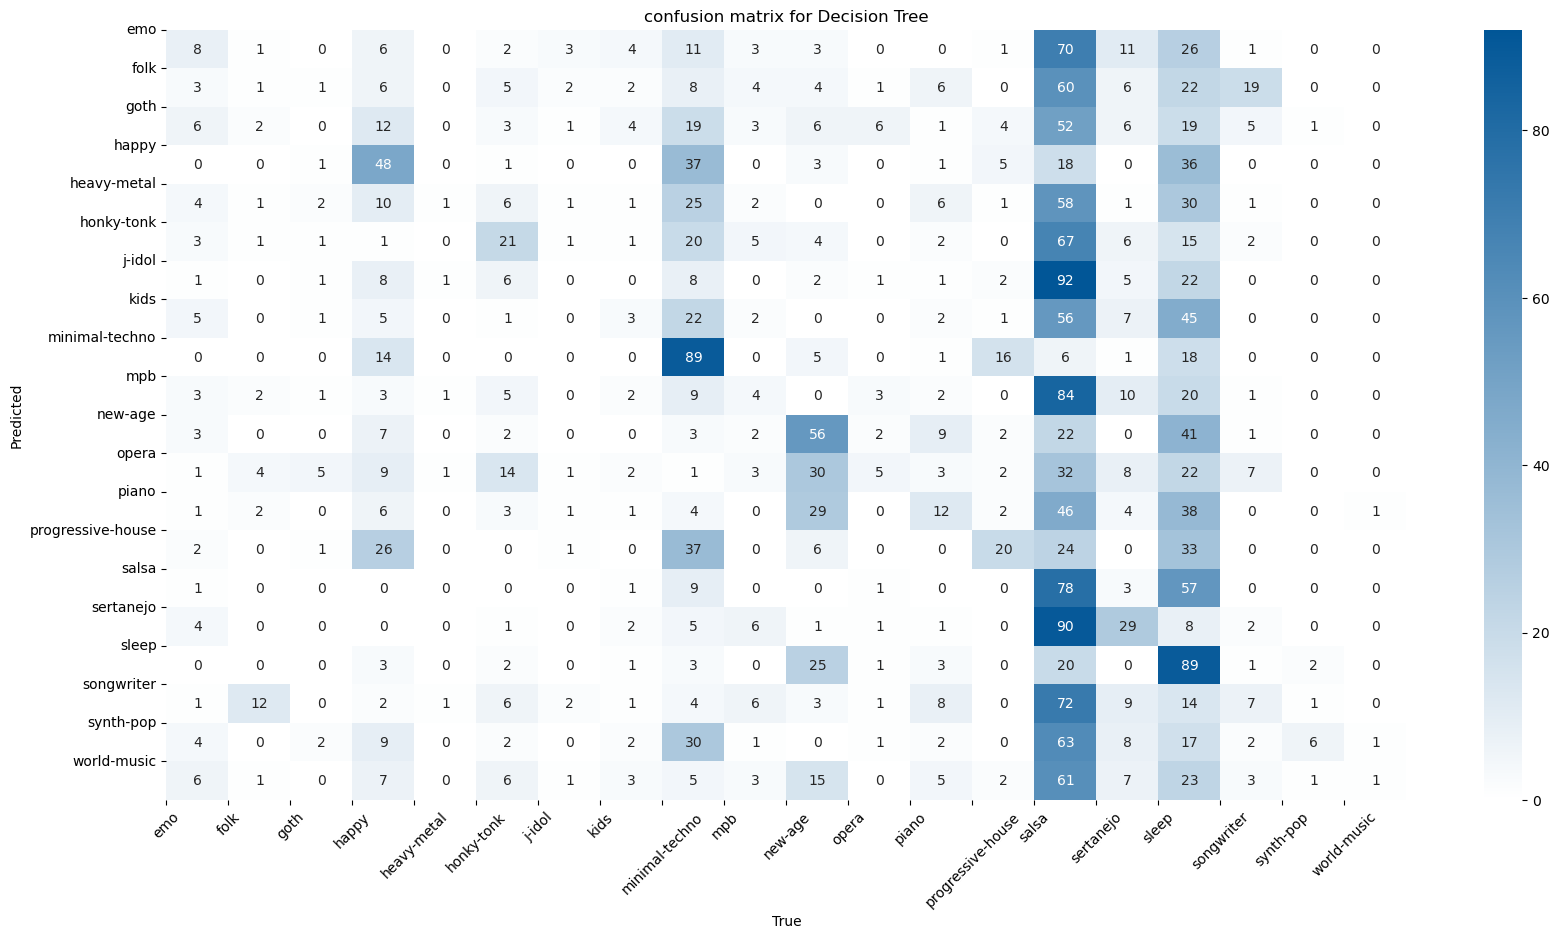

In [87]:
cf = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (20, 10))
sns.heatmap(cf, annot=True, cmap=cmap, fmt=".3g")

plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("confusion matrix for Decision Tree")

plt.xticks(range(len(knn_dtw.classes_)), knn_dtw.classes_, rotation = 45)
plt.yticks(range(len(knn_dtw.classes_)), knn_dtw.classes_, rotation = 360)

plt.show()

In [ ]:
roc_auc_score(y_test, knn_dtw.predict_proba(X_test_scaled_f), multi_class="ovr", average="macro")

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 3000 1-dimensional timeseries
  warnings.warn(


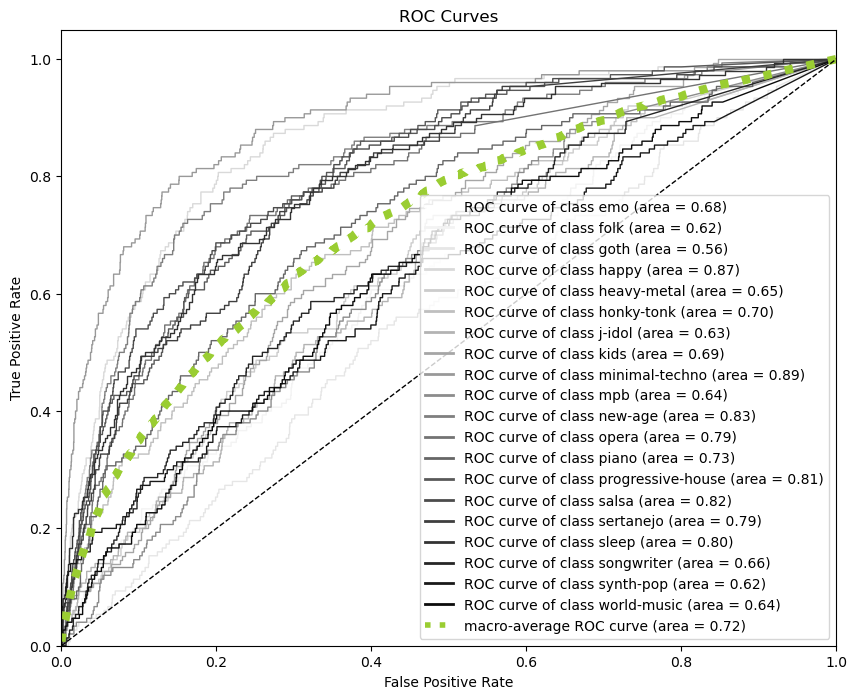

In [89]:
y_test_pred_proba = knn_dtw.predict_proba(X_test_scaled_f)
plot_roc_cust(y_test, y_test_pred_proba)